In [6]:
import os
import pickle
import math
import time
from random import random
import xml.etree.ElementTree as ET
import numpy as np
import albumentations as A
import cv2 as cv
from dataclasses import dataclass, field
from functools import partial
from random import randint
import html
import random
from pathlib import Path
from typing import Union, Tuple, Dict, Sequence, Optional, List, Any, Callable, Optional
import pandas as pd
from torch import Tensor, nn
from torch.utils.data import Dataset
from PIL import Image
from torchmetrics import Metric
import torch
from torchvision import models
from torch.utils.data import Dataset
import editdistance
import wandb
from torch.utils.data.dataloader import DataLoader
from torch.optim import Optimizer
import torch.optim as optim
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
class LabelParser:
    def __init__(self):
        self.classes = None
        self.vocab_size = None
        self.class_to_idx = None
        self.idx_to_class = None

    def fit(self, classes: Sequence[str]):
        self.classes = list(classes)
        self.vocab_size = len(classes)
        self.idx_to_class = dict(enumerate(classes))
        self.class_to_idx = {cls: i for i, cls in self.idx_to_class.items()}

        return self

    def addClasses(self, classes: List[str]):
        all_classes = sorted(set(self.classes + classes))

        self.fit(all_classes)

    def encode_labels(self, sequence: Sequence[str]):
        self._check_fitted()
        return [self.class_to_idx[c] for c in sequence]

    def decode_labels(self, sequence: Sequence[int]):
        self._check_fitted()
        return [self.idx_to_class[c] for c in sequence]

    def _check_fitted(self):
        if self.classes is None:
            raise ValueError("LabelParser class was not fitted yet")


def pickle_load(file) -> Any:
    with open(file, "rb") as f:
        return pickle.load(f)


def pickle_save(obj, file):
    with open(file, "wb") as f:
        pickle.dump(obj, f)


def read_xml(file: Union[Path, str]) -> ET.Element:
    tree = ET.parse(file)
    root = tree.getroot()

    return root


def find_child_by_tag(element: ET.Element, tag: str, value: str) -> Union[ET.Element, None]:
    for child in element:
        if child.get(tag) == value:
            return child
    return None


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def dpi_adjusting(img: np.ndarray, scale: float, **kwargs) -> np.ndarray:
    height, width = img.shape[:2]
    new_height, new_width = math.ceil(height * scale), math.ceil(width * scale)
    return cv.resize(img, (new_width, new_height))


class LitProgressBar(TQDMProgressBar):
    def get_metrics(self, trainer, model):
        # don't show the version number
        items = super().get_metrics(trainer, model)
        for k in list(items.keys()):
            if k.startswith("grad"):
                items.pop(k, None)
        items.pop("v_num", None)
        return items


def decode_prediction_and_target(
        pred: Tensor, target: Tensor, label_encoder: LabelParser, eos_tkn_idx: int
) -> Tuple[str, str]:
    # Find padding and <EOS> positions in predictions and targets.
    eos_idx_pred = (pred == eos_tkn_idx).float().argmax().item()
    eos_idx_tgt = (target == eos_tkn_idx).float().argmax().item()

    # Decode prediction and target.
    p, t = pred.tolist(), target.tolist()
    p = p[1:]  # skip the initial <SOS> token, which is added by default
    p = p[:eos_idx_pred] if eos_idx_pred != 0 else p
    t = t[:eos_idx_tgt] if eos_idx_tgt != 0 else t
    pred_str = "".join(label_encoder.decode_labels(p))
    target_str = "".join(label_encoder.decode_labels(t))
    return pred_str, target_str


def matplotlib_imshow(
        img: torch.Tensor, mean: float = 0.5, std: float = 0.5, one_channel=True
):
    assert img.device.type == "cpu"
    if one_channel and img.ndim == 3:
        img = img.mean(dim=0)
    img = img * std + mean  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


## Image transformations


class SafeRandomScale(A.RandomScale):
    def apply(self, img, scale=0, interpolation=cv.INTER_LINEAR, **params):
        height, width = img.shape[:2]
        new_height, new_width = int(height * scale), int(width * scale)
        if new_height <= 0 or new_width <= 0:
            return img
        return super().apply(img, scale, interpolation, **params)


def adjust_dpi(img: np.ndarray, scale: float, **kwargs):
    height, width = img.shape
    new_height, new_width = math.ceil(height * scale), math.ceil(width * scale)
    return cv.resize(img, (new_width, new_height))


def randomly_displace_and_pad(
        img: np.ndarray,
        padded_size: Tuple[int, int],
        crop_if_necessary: bool = False,
        **kwargs,
) -> np.ndarray:
    """
    Randomly displace an image within a frame, and pad zeros around the image.

    Args:
        img (np.ndarray): image to process
        padded_size (Tuple[int, int]): (height, width) tuple indicating the size of the frame
        crop_if_necessary (bool): whether to crop the image if its size exceeds that
            of the frame
    """
    frame_h, frame_w = padded_size
    img_h, img_w = img.shape
    if frame_h < img_h or frame_w < img_w:
        if crop_if_necessary:
            print(
                "WARNING (`randomly_displace_and_pad`): cropping input image before "
                "padding because it exceeds the size of the frame."
            )
            img_h, img_w = min(img_h, frame_h), min(img_w, frame_w)
            img = img[:img_h, :img_w]
        else:
            raise AssertionError(
                f"Frame is smaller than the image: ({frame_h}, {frame_w}) vs. ({img_h},"
                f" {img_w})"
            )

    res = np.zeros((frame_h, frame_w), dtype=img.dtype)

    pad_top = randint(0, frame_h - img_h)
    pad_bottom = pad_top + img_h
    pad_left = randint(0, frame_w - img_w)
    pad_right = pad_left + img_w

    res[pad_top:pad_bottom, pad_left:pad_right] = img
    return res


@dataclass
class ImageTransforms:
    max_img_size: Tuple[int, int]  # (h, w)
    normalize_params: Tuple[float, float]  # (mean, std)
    scale: float = (
        0.5
    )
    random_scale_limit: float = 0.1
    random_rotate_limit: int = 10

    train_trnsf: A.Compose = field(init=False)
    test_trnsf: A.Compose = field(init=False)

    def __post_init__(self):
        scale, random_scale_limit, random_rotate_limit, normalize_params = (
            self.scale,
            self.random_scale_limit,
            self.random_rotate_limit,
            self.normalize_params
        )

        max_img_h, max_img_w = self.max_img_size
        max_scale = scale + scale * random_scale_limit
        padded_h, padded_w = math.ceil(max_scale * max_img_h), math.ceil(max_scale * max_img_w)

        self.train_trnsf = A.Compose([
            A.Lambda(partial(adjust_dpi, scale=scale)),
            SafeRandomScale(scale_limit=random_scale_limit, p=0.5),
            A.SafeRotate(
                limit=random_rotate_limit,
                border_mode=cv.BORDER_CONSTANT,
                value=0
            ),
            A.RandomBrightnessContrast(),
            A.Perspective(scale=(0.01, 0.05)),
            A.GaussNoise(),
            A.Normalize(*normalize_params),
            A.Lambda(
                image=partial(
                    randomly_displace_and_pad,
                    padded_size=(padded_h, padded_w),
                    crop_if_necessary=False,
                )
            )
        ])

        self.test_trnsf = A.Compose([
            A.Lambda(partial(adjust_dpi, scale=scale)),
            A.Normalize(*normalize_params),
            A.PadIfNeeded(
                max_img_h, max_img_w, border_mode=cv.BORDER_CONSTANT, value=0
            )
        ])




In [7]:
import time
class RIMESDataset(Dataset):
    MAX_FORM_HEIGHT = 3542
    MAX_FORM_WIDTH = 2479
    MEAN = 0.8275
    STD = 0.2314
    
    root: Path
    data: pd.DataFrame
    label_enc: LabelParser
    transforms: Optional[A.Compose]
    id_to_idx: Dict[str, int]
    _split: str
    _return_writer_id: Optional[bool]
    
    _pad_token = "<PAD>"
    _sos_token = "<SOS>"
    _eos_token = "<EOS>"
    
    max_width: Optional[int]
    max_height: Optional[int]
    
    @staticmethod
    def process_target(target: str):
    # Splitting the input string into lines
        lines = target.split("\\n")
        
        new_lines = []
        for line in lines:
            new_line = line
            start_index = new_line.find("¤{")
            
            while start_index != -1:
                # Find the corresponding closing bracket
                end_index = new_line.find("¤", start_index + 1)
                if end_index == -1:
                    break  # Safety check
    
                # Extract the sequence between markers
                seq = new_line[start_index + 2:end_index]
                choices = seq.split("/")
                # Random selection from the available options
                val = choices[randint(0, len(choices) - 1)]
    
                # Replace the content within the markers with the selected value
                new_line = new_line[:start_index] + " " + val + " " + new_line[end_index + 1:]
                
                # Update the position for the next search
                start_index = new_line.find("¤{", start_index + 1)
            
            new_lines.append(new_line)
        
        return "\n".join(new_lines)
    
    def __init__(
            self,
            root: Union[Path, str],
            split: str, 
            only_lowercase: bool = False,
            label_enc: Optional[LabelParser] = None,):
        super().__init__()
        
        _splits = ["train", "test"]
        err_message = f"{split} is not a possible split: {_splits}"
        assert split in _splits, err_message
        
        self._split = split
        self.only_lowercase = only_lowercase
        self.root = Path(root)
        self.label_enc = label_enc
        
        if not hasattr(self, "data"):
            self.data = self._get_form_data()
        
        if self.label_enc is None:
            vocab = [self._pad_token, self._sos_token, self._eos_token]
            s = "".join(self.data["target"].tolist())
            if self.only_lowercase:
                s = s.lower()
            vocab += sorted(list(set(s)))
            self.label_enc = LabelParser().fit(vocab)
            
        if not "target_enc" in self.data.columns:
            self.data.insert(
                2,
                "target_enc",
                self.data["target"].apply(
                    lambda s: np.array(
                        self.label_enc.encode_labels(
                            [c for c in (s.lower() if self.only_lowercase else s)]
                        )
                    )
                )
            )
        self.transforms = self._get_transforms(split)
        self.id_to_idx = {
            Path(self.data.iloc[i]["img_path"]).stem: i for i in range(len(self))
        }
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        img = cv.imread(data["img_path"], cv.IMREAD_GRAYSCALE)
        
        if all(col in data.keys() for col in ["bb_y_start", "bb_y_end"]):
            img = img[data["bb_y_start"]: data["bb_y_end"], :]
        assert isinstance(img, np.ndarray), (
            f"Error: image at path {data['img_path']} is not properly loaded. "
            f"Is there something wrong with this image?"
        )
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        
        return img, data["target_enc"]
    
    def get_max_height(self):
        return (self.data["bb_y_end"] - self.data["bb_y_start"]).max() + 150
    
    def get_max_width(self):
        return (self.data["bb_x_end"] - self.data["bb_x_start"]).max() + 150
    
    @property
    def vocab(self):
        return self.label_enc.classes
        
    @staticmethod
    def collate_fn(
        batch: Sequence[Tuple[np.ndarray, np.ndarray]],
        pad_val: int,
        eos_tkn_idx: int,
        dataset_returns_writer_id: bool = False,
    ) -> Union[Tuple[Tensor, Tensor], Tuple[Tensor, Tensor, Tensor]]:
        
        imgs, targets = zip(*batch)

        img_sizes = [im.shape for im in imgs]
        if not len(set(img_sizes)) == 1:
            hs, ws = zip(*img_sizes)
            pad_fn = A.PadIfNeeded(
                max(hs), max(ws), border_mode=cv.BORDER_CONSTANT, value=0
            )
            imgs = [pad_fn(image=im)["image"] for im in imgs]
        imgs = np.stack(imgs, axis=0)

        seq_lengths = [t.shape[0] for t in targets]
        targets_padded = np.full((len(targets), max(seq_lengths) + 1), pad_val)
        for i, t in enumerate(targets):
            targets_padded[i, : seq_lengths[i]] = t
            targets_padded[i, seq_lengths[i]] = eos_tkn_idx

        imgs, targets_padded = torch.tensor(imgs), torch.tensor(targets_padded)
        
        
        return imgs, targets_padded
    
    def _get_transforms(self, split: str) -> A.Compose:
        max_img_w = self.max_width
    
        max_img_h = self.max_height
    
        transforms = ImageTransforms(
            (max_img_h, max_img_w), (RIMESDataset.MEAN, RIMESDataset.STD)
        )
    
        if split == "train":
            return transforms.train_trnsf
        elif split == "test" or split == "val":
            return transforms.test_trnsf
    

    def _get_form_data(self):
        data = {
            "img_path": [],
            "img_id": [],
            "target": [],
            "bb_y_start": [],
            "bb_y_end": [],
            "bb_x_start": [],
            "bb_x_end": [],
            "target_len": [],
        }
        
        
        def process_forms(paths: Tuple[str, str, Path]):
            return_data = {
                "img_path": [],
                "img_id": [],
                "target": [],
                "bb_y_start": [],
                "bb_y_end": [],
                "bb_x_start": [],
                "bb_x_end": [],
                "target_len": []
            }
            img_path, xml_path, root = paths
            img_path = root / img_path
            xml_path = root / xml_path
            doc_id = img_path.stem[:-2]
            xml_root = read_xml(xml_path)
            
            bb_y_start, bb_y_end, bb_x_start, bb_x_end = None, None, None, None
            target = ""
            num_corps = 0
            for box in xml_root.iter("box"):
                type_tag =  box.find("type")
                if type_tag.text == "Corps de texte":
                    target = box.find("text").text
                    if target is None or target == "":
                        continue
                    words = target.split("\\n")
                    if len(words) <= 5:
                        continue
                    bb_y_start = box.get("top_left_y")
                    bb_y_end   = box.get("bottom_right_y")
                    bb_x_start = box.get("top_left_x")
                    bb_x_end   = box.get("bottom_right_x")
                    
                    return_data["img_path"].append(str(img_path.resolve()))
                    return_data["img_id"].append(doc_id)
                    return_data["target"].append(self.process_target(target))
                    return_data["bb_y_start"].append(int(bb_y_start))
                    return_data["bb_y_end"].append(int(bb_y_end))
                    return_data["bb_x_start"].append(int(bb_x_start))
                    return_data["bb_x_end"].append(int(bb_x_end))
                    return_data["target_len"].append(len(target))
                    num_corps += 1
            
            
            # print(return_data["img_path"])
            
            return return_data
        
        image_pairs = []
        for form_dir in ["DVD1_TIF", "DVD2_TIF", "DVD3_TIF"]:
            dr = self.root / form_dir
            for file in dr.iterdir():
                name = file.stem
                ext = file.suffix
                if ext == ".tif" and name[-1] == "L":
                    image_pairs.append((name + ".tif", name + ".xml", dr))
        
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(process_forms, iter(image_pairs)))
            
            for single_results in results:
                if single_results["img_path"] == "":
                    continue
                data["img_path"].extend(single_results["img_path"])
                data["img_id"].extend(single_results["img_id"])
                data["target"].extend(single_results["target"])
                data["bb_y_start"].extend(single_results["bb_y_start"])
                data["bb_y_end"].extend(single_results["bb_y_end"])
                data["bb_x_start"].extend(single_results["bb_x_start"])
                data["bb_x_end"].extend(single_results["bb_x_end"])
                data["target_len"].extend(single_results["target_len"])
        
        to_ret = pd.DataFrame(data)
        self.max_height = (to_ret["bb_y_end"] - to_ret["bb_y_start"]).max() + 150
        self.max_width = (to_ret["bb_x_end"] - to_ret["bb_x_start"]).max() + 150
        
        return to_ret

In [8]:
from pytorch_lightning import seed_everything
seed_everything(12345)
ds = RIMESDataset(root="/Users/tefannastasa/BachelorsWorkspace/BachModels/BachModels/data/raw/RIMES", label_enc=None, split="train")

len(ds)


Seed set to 12345


4807

In [9]:
from src.IAMDataset import IAMDatasetSynthetic
from tqdm import tqdm

imgs = []
for sample in tqdm(ds):
    imgs.append(sample[0])
print(len(imgs))


100%|██████████| 4807/4807 [04:21<00:00, 18.40it/s]

4807


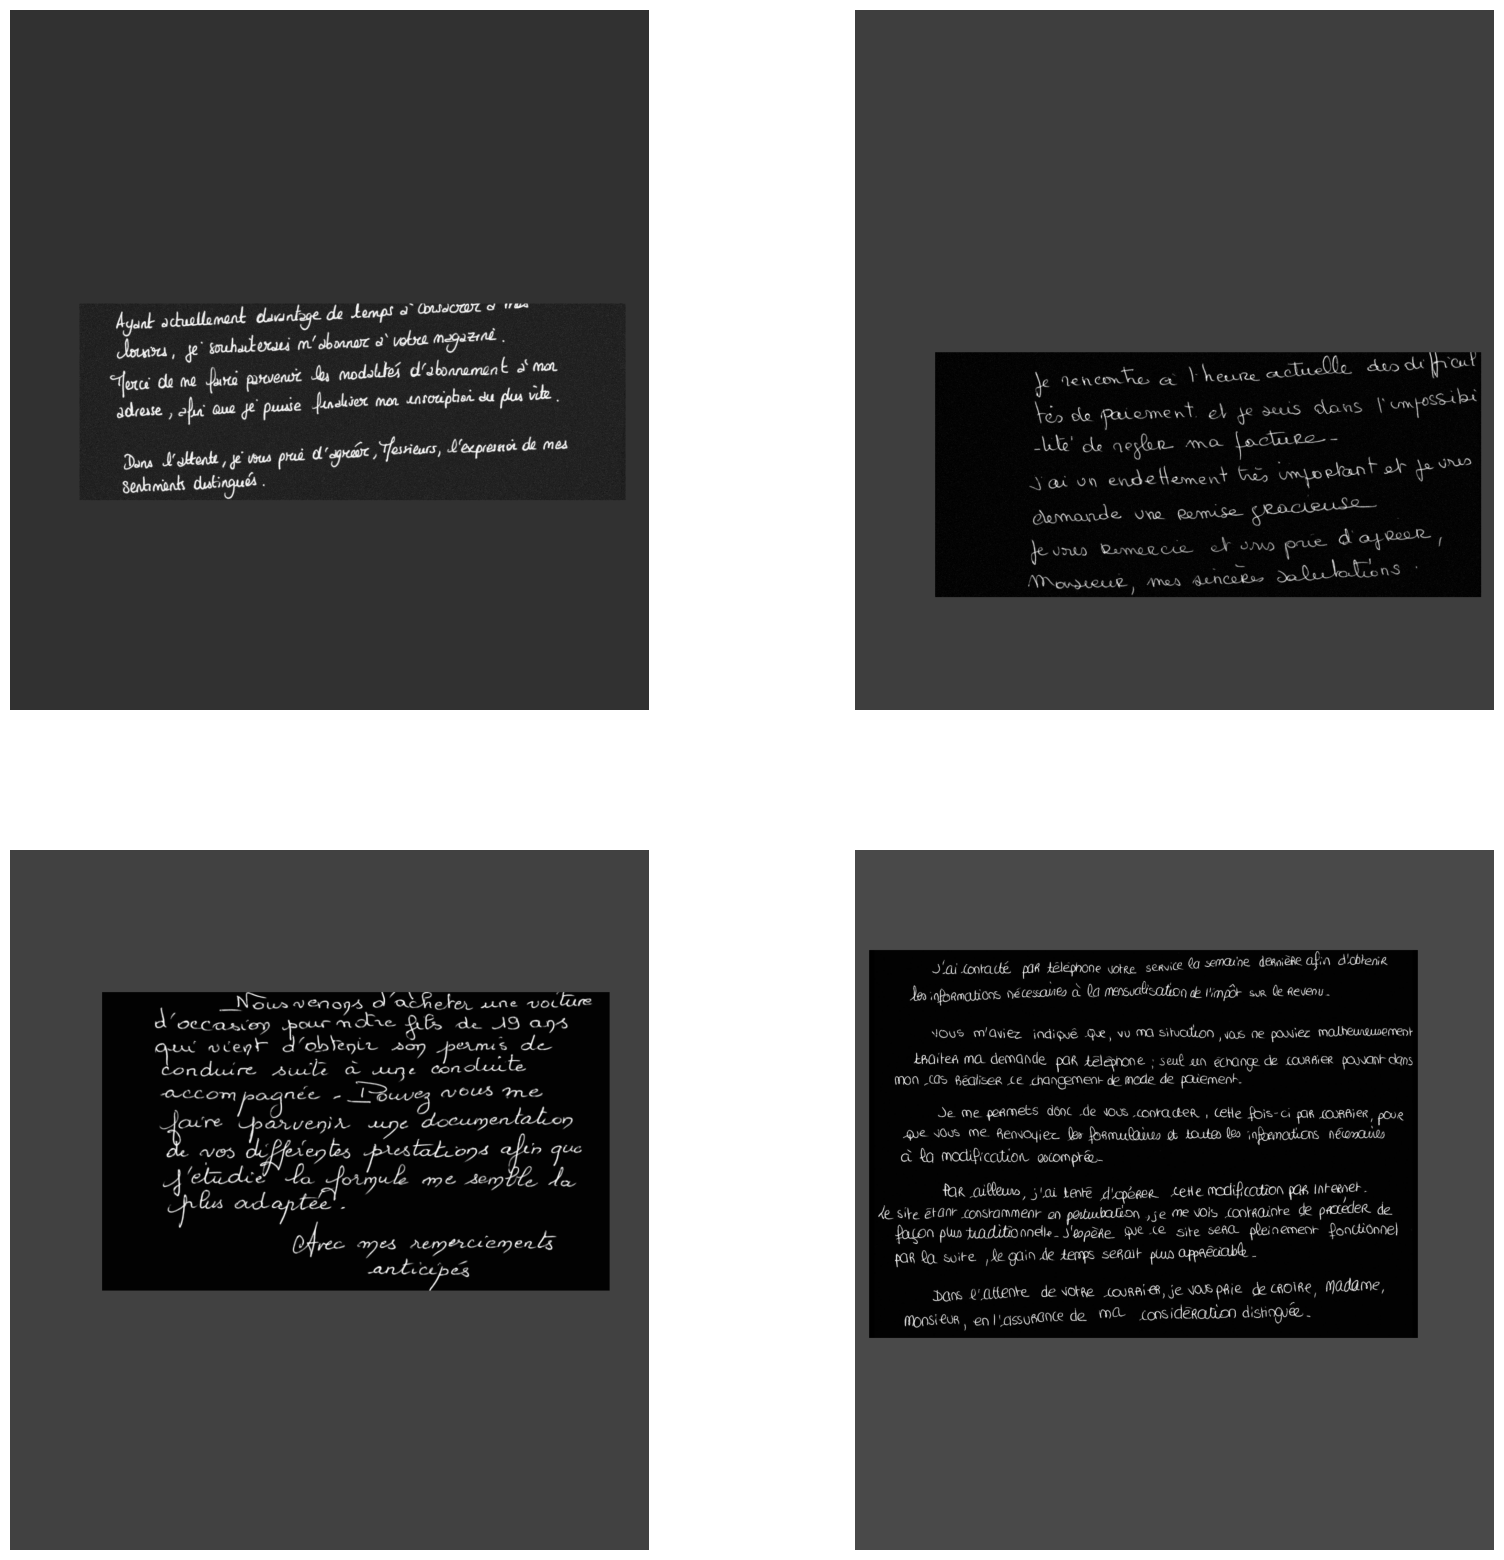

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))  # Adjust figsize as needed
for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        np = imgs[i]
        
        ax.imshow(np, cmap="Greys")
        ax.axis('off')  
    else:
        ax.axis('off')